### Here, I check jun rui's simulation results for:


Knapsack Problem (Capacity: 2)
Profits: 4.0 4.0
Weights: 3.0 2.0
Max beta: 6.025595860743581
0.0 -4.0
-32.97342056282295 -39.95499222533249

In [51]:
import numpy as np
from scipy.linalg import expm
import scipy
import matplotlib.pyplot as plt
import time

In [52]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

In [53]:
sigmaI = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
sigmaX = np.array(
    [
        [0, 1],
        [1, 0],
    ]
)
sigmaBin = np.array(
    [
        [0, 0],
        [0, 1],
    ]
)

In [54]:
Values = [4, 4]
Weights = [3, 2]
Ancil = [1, 1]
num_dimension = 2**(len(Values) + len(Ancil))

alpha = 1
beta = 1
gamma = max(Values) + 1
T = 1e1
dt = 0.01
t_axis = np.arange(0, T, dt)[0:]

In [55]:
# Create creation operator
a_dag = np.zeros((num_dimension, num_dimension))
n_indices = np.arange(num_dimension - 1)
a_dag[n_indices + 1, n_indices] = np.sqrt(n_indices + 1)
# print(a_dag)

# Create annihilation operator
a = np.zeros((num_dimension, num_dimension))
n_indices = np.arange(1, num_dimension)
a[n_indices - 1, n_indices] = np.sqrt(n_indices)
# print(a)

# print(a_dag @ a)

In [56]:
H0 = (a_dag + a)
# print(H0)

eigenvals_H0, eigenvecs_H0 = np.linalg.eigh(H0)
ground_idx_H0 = eigenvals_H0.argsort()[0]
print(eigenvals_H0[ground_idx_H0])
print(eigenvecs_H0[:, ground_idx_H0])

-6.630878198393129
[-0.     0.    -0.     0.001 -0.004  0.011 -0.026  0.056 -0.106  0.182
 -0.281  0.389 -0.475  0.5   -0.428  0.25 ]


In [57]:
eyes = [sigmaI for _ in range(len(Values) + len(Ancil))]
profit_matrix = np.zeros((num_dimension, num_dimension))
weight_matrix = np.zeros((num_dimension, num_dimension))
penalty_matrix = np.zeros((num_dimension, num_dimension))

for i in range(len(Values)):
    nose = eyes.copy()
    nose[i] = sigmaBin
    tensorproduct = nose[0]
    for sigma in nose[1:]:
        tensorproduct = np.kron(tensorproduct, sigma)
    profit_matrix += Values[i] * tensorproduct
    weight_matrix += Weights[i] * tensorproduct
    
for j in range(len(Ancil)):
    nose = eyes.copy()
    nose[j + len(Values)] = sigmaBin
    tensorproduct = nose[0]
    for sigma in nose[1:]:
        tensorproduct = np.kron(tensorproduct, sigma)
    penalty_matrix += Ancil[j] * tensorproduct

Hp = -profit_matrix + gamma * (weight_matrix - penalty_matrix)**2


eigenvals_Hp, eigenvecs_Hp = np.linalg.eigh(Hp)
print(eigenvals_Hp)
print(eigenvals_Hp.argsort())
ground_idx_Hp = eigenvals_Hp.argsort()[0]
ground_idx_Hp_degen = eigenvals_Hp.argsort()[1]
print(eigenvals_Hp[ground_idx_Hp])
print(eigenvecs_Hp[:, ground_idx_Hp])
print(eigenvals_Hp[ground_idx_Hp_degen])
print(eigenvecs_Hp[:, ground_idx_Hp_degen])



[ -4.   0.   1.   1.   1.   5.   5.  16.  16.  16.  20.  37.  41.  72.
  72. 117.]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
-4.0
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [58]:
def H(t, T=1, alpha=1, beta=1):
    return alpha * ( (1 - t/T)*beta*H0 + (t/T)*Hp )

In [59]:
psi_ini = eigenvecs_H0[:, ground_idx_H0]
# print(psi_ini)
# print(np.linalg.norm(psi_ini))

psi_correct = eigenvecs_Hp[:, ground_idx_Hp]
if eigenvals_Hp[ground_idx_Hp] == eigenvals_Hp[ground_idx_Hp_degen]:
    psi_correct_degen = eigenvecs_Hp[:, ground_idx_Hp_degen]
else:    
    psi_correct_degen = np.zeros(eigenvecs_Hp[:, ground_idx_Hp_degen].shape)
print(psi_correct)
print(psi_correct_degen)

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


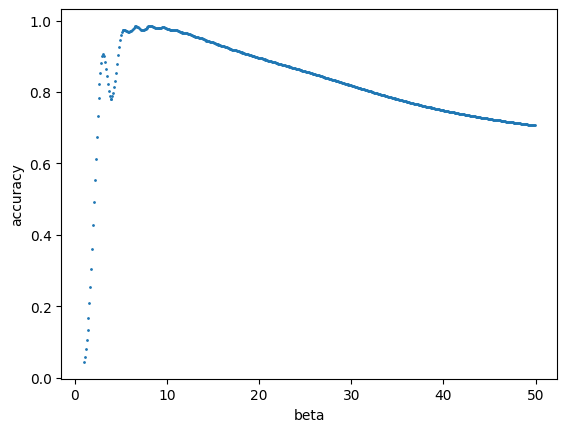

72
max accuracy: 0.9848815902599439
beta_optimal: 8.200000000000006


In [60]:
beta_list = np.arange(1e0, 5e1, 1e-1)
accuracy_list = []

for beta in beta_list:
    start_time = time.time()

    junrui_unitary = np.identity(len(H0))
    for t in t_axis:
        junrui_unitary = expm(-1j * H(t, T=T, alpha=alpha, beta=beta) * dt) @ junrui_unitary

    psi_final = junrui_unitary @ psi_ini

    accuracy = np.abs( np.dot(psi_correct, psi_final) )**2 + np.abs( np.dot(psi_correct_degen, psi_final) )**2
    accuracy_list.append(accuracy)

    end_time = time.time()
    # print(f"beta = {beta}, loop time: {end_time - start_time}")

plt.scatter(beta_list, accuracy_list, s=1)
plt.xlabel("beta")
plt.ylabel("accuracy")
plt.show()
accuracy_list = np.array(accuracy_list)
print(accuracy_list.argmax())
print(f"max accuracy: {accuracy_list[accuracy_list.argmax()]}")
print(f"beta_optimal: {beta_list[accuracy_list.argmax()]}")


In [61]:
"""Values = [4, 4]
Weights = [3, 2]
Ancil = [1, 1]
num_dimension = 2**(len(Values) + len(Ancil))

alpha = 1
beta = 1
gamma = max(Values) + 1
T = 1e1
dt = 0.01
t_axis = np.arange(0, T, dt)[0:]"""

'Values = [4, 4]\nWeights = [3, 2]\nAncil = [1, 1]\nnum_dimension = 2**(len(Values) + len(Ancil))\n\nalpha = 1\nbeta = 1\ngamma = max(Values) + 1\nT = 1e1\ndt = 0.01\nt_axis = np.arange(0, T, dt)[0:]'